In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
data = pd.read_csv('data.csv')
# Iremos lidar apenas com números
data = data.select_dtypes(include='number').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
data_train = data[:500]
a_none = np.array([None])

In [113]:
len(a_none)

1

In [114]:
'''Criando uma classe contendo algumas ferramentas para executar o least square'''
class LR():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.predictions=a_none
        self.parametros=a_none

        
    def least_square(self):
        # Transpose na matrix com as variáveis
        row_x = self.x.T
        dot_x = row_x.dot(self.x)
        invert_dotx = np.linalg.inv(dot_x)
        self.parametros = invert_dotx.dot(row_x).dot(self.y)
        
        return invert_dotx.dot(row_x).dot(self.y)

    def prediction(self, x=a_none):
        if self.parametros.all() == None:
            self.parametros = self.least_square()

        if x.all() == None:
            self.predictions = self.x.dot(self.parametros)
            return self.x.dot(self.parametros)
        else:
            return x.dot(self.parametros)

    def MSE(self, y_hat=a_none, y=a_none): 
        # Quantia de resultados
        if y_hat.all() == None:
            self.predictions = self.prediction(self.x)
            self.mse = (self.predictions - self.y).T.dot((self.predictions - self.y)) / len(self.y)
            return self.mse
        
        else:
            return (y_hat - y).T.dot((y_hat - y)) / len(y)
    
    '''Uma das formas de tentar selecionar os melhores features
    do modelo, assim podemos diminuir a quantia de variáveis'''
    def Forward_selection(self, n_feature):
        # Manter as dimensão do data-set
        axis_x, axis_y = self.x.shape
        # Copiar a data-set pois serão feitas alterações nele
        x = self.x
        # A cada iteração a variável escolhido virá para cá
        select_feature = np.ones([axis_x, n_feature+1])

        pos_select = [0]
        for i in range(1, n_feature+1):

            predict = np.inf

            # Mantém a primeira coluna para o intercept e das variáveis já selecionadas
            feature = np.array(select_feature[:,:i+1])
            select = 0
            for j in range(1, axis_y-i+1):

                feature[:, i] = x[:, j]
                mse = LR(feature, self.y).MSE()
                # Encontra a variável que produziu menor mse
                if (mse < predict):
                    predict = mse
                    select = j
            
            # Variável escolhida é adicionada ao data-set das escolhas
            select_feature[:, i] = x[:, select]
            pos_select.append(i)
            # Variável escolhida é excluída do data-set das buscas
            x = np.delete(x, select, axis=1)

        return select_feature, pos_select
    
    def Backward_selection(self, n_feature):
        # n_feature demonstra quantia de feature deleted
        
        # Manter as dimensão do data-set
        axis_x, axis_y = self.x.shape
        # Copiar a data-set pois serão feitas alterações nele
        x = self.x
        # Manter um data-set auxiliar para sabermos as colunas deletadas
        x_aux = x.copy()
        # A quantia de feature que teremos no data-set
        select_feature = axis_y - n_feature
        pos_deleted = []
        select = 0
        for i in range(1, select_feature):
            predict = -np.inf

            for j in range(1, axis_y-i+1):

                feature = np.delete(x, j, axis=1)
                mse = LR(feature, self.y).MSE()
                # Encontra a variável que produziu maior mse
                if (mse > predict):
                    predict = mse
                    select = j 
                    col_deleted = x[:,select]
            
            # Variável com maior mse é excluída do data-set
            x = np.delete(x, select, axis=1)
            for i in range(axis_y):
                if (x_aux[:,i] == col_deleted).all():
                    pos_deleted.append(i)

        return x, pos_deleted
    
    '''Outra forma de alterar o least square solution buscando uma mse menor, nesse método, a alteração
    dos parâmetros é feita de forma continua e não havendo exclusões de variáveis'''
    def Ridge_Regression(self, ratio, x=a_none, y=a_none):
        if len(x) == 1:
            if (self.x[:,0] == 1).all():
                x = np.delete(self.x, 0, axis=1)
            for i in range(x.shape[1]):
                x[:, i] = (x[:, i] - np.mean(x[:, i]))/np.var(x[:, i])
            
            ridge = np.linalg.inv((x.T.dot(x) + ratio*np.identity(x.shape[1]))).dot(x.T).dot(self.y)
        else: 
            x = np.array(x)
            if (x[:,0] == 1).all():
                x = np.delete(x, 0, axis=1)
            for i in range(x.shape[1]):
                x[:, i] = (x[:, i] - np.mean(x[:, i]))
            ridge = np.linalg.inv((x.T.dot(x) + ratio*np.identity(x.shape[1]))).dot(x.T).dot(y)
            
        return np.append(np.mean(self.y), ridge)

In [115]:
# Selecionando a coluna da variável e prediction
np_data = data_train[['price', 'spec_rating']].to_numpy()

np_x = np_data.T[1]
np_y = np_data.T[0]

# Adicionando uma coluna com 1 em np_x
np_x = np.array([np.ones(500), np_x]).T

dim_1 = LR(np_x, np_y) 

# Parâmetros calculado pelo least squre
B = dim_1.least_square()
# Prevendo resultado
y_hat = dim_1.prediction()
# Mean Square Error testando a qualidade do modelo
mse_dim1 = dim_1.MSE()
print(mse_dim1)

2457696370.0598817


In [116]:
'''A equação least square para mais de uma variável não é a mesma casos os dados
não sejam transformados, no least square há uma operação entre variáveis chamada
inner product que resultam em 0 casos os dados são ortogonais, assim iremos transforma-los
em ortogonais para aproveitar a mesma equação do caso com 1 dimensão'''

def residual(u, v):
    return u - (projection(u, v))

def projection(u, v):
    return (np.dot(u,v) / np.dot(v,v)) * v

# Função para deixar os dados ortogonais
def gram_schmidt(dataset):

    orthogonal = pd.DataFrame()
    colunas = dataset.columns

    for i in range(len(colunas)):
        v = dataset.iloc[:, i]
        for j in range(i):
            proj = projection(dataset.iloc[:, i], orthogonal.iloc[:, j])
            v = v - proj
        orthogonal[colunas[i]] = v 
    return orthogonal

In [117]:
# Data com mais de 1 variável
data_train

,price,spec_rating,display_size,resolution_width,resolution_height,warranty
0,49900,73.000000,15.6,1920.0,1080.0,1
1,39900,60.000000,15.6,1920.0,1080.0,1
2,26990,69.323529,14.0,1920.0,1080.0,1
3,59729,66.000000,14.0,2240.0,1400.0,1
4,69990,69.323529,13.3,2560.0,1600.0,1
...,...,...,...,...,...,...
495,59900,69.323529,15.6,1920.0,1080.0,1
496,55990,69.323529,14.0,1920.0,1080.0,1
497,19990,69.323529,15.6,1920.0,1080.0,1
498,47990,63.000000,14.0,2160.0,1440.0,1


In [118]:
multi_data  = gram_schmidt(data_train)
# Os mesmos dados depois da ortogonalizados
multi_data

,price,spec_rating,display_size,resolution_width,resolution_height,warranty
0,49900,42.026128,-0.581678,-108.583224,-64.154312,-0.089732
1,39900,35.233317,2.294516,128.732709,28.460823,0.022862
2,26990,52.570327,-1.466991,113.034744,-58.454783,-0.012584
3,59729,28.925082,-0.558172,352.132971,92.852173,0.021250
4,69990,25.879415,-1.955616,612.913343,82.849719,0.013045
...,...,...,...,...,...,...
495,59900,32.142468,0.294784,-92.923241,-48.202254,-0.057162
496,55990,34.569479,-1.324436,-3.286348,-81.604057,-0.010939
497,19990,56.915359,0.098599,67.158648,-16.344064,-0.059426
498,47990,33.211701,0.059203,364.727842,202.802435,0.049160


In [119]:
# inner product entre as duas colunas resultando em um valor bem próximo de 0
sum(multi_data.iloc[:,4] * multi_data.iloc[:,2])

7.38766964269999e-11

In [120]:
# Separando as variáveis do predictor
x = multi_data.iloc[:,1:]

train_data = np.ones([500, 6])
train_data[:, 1:] = x

multi_dim = LR(train_data, np_y)

BB = multi_dim.least_square()
yy_hat = multi_dim.prediction(train_data)
mse_mult = multi_dim.MSE(yy_hat, np_y)
print("MSE test: ",mse_mult)

# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(np_y - yy_hat) / np.mean(np_y)
print("erro médio :", erro_medio) 

MSE test:  26189451.566836577
erro médio : 7.054046990610018e-16


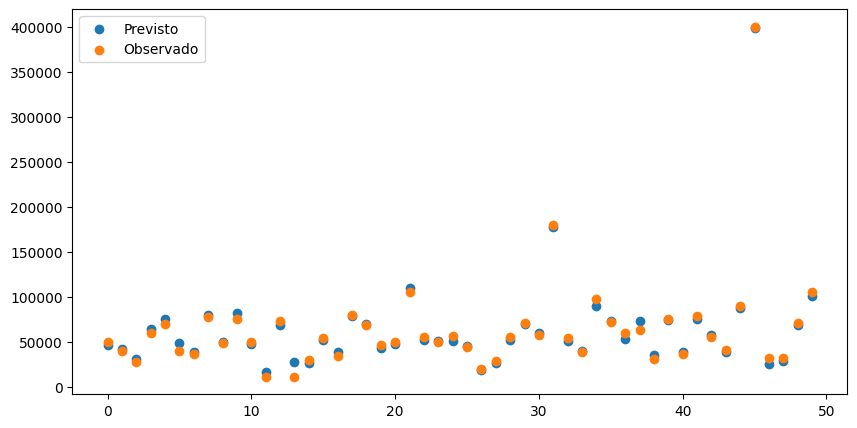

In [121]:
'''MSE não é a melhor métrica para interpretar a qualidade do modelo (outro problema para nós é a 
moeda utilizada, a escala é maior que o acostumado com o real). Uma solução seria criar métricas
que podemos interpretar, e em alguns casos figuras também podem podem ajudar na interpretação.
Foram selecionados os 50 primeiros dados para que coubessem na imagem, podemos ver que o modelo se sai 
bem em prever os preços'''

plt.figure(figsize=(10,5))
plt.scatter(range(50), yy_hat[:50], label='Previsto')
plt.scatter(range(50), np_y[:50], label='Observado')
plt.legend()

In [122]:
data_test = data[500:]
data_test = gram_schmidt(data_test)
# Separando as variáveis do predictor
x_test = data_test.iloc[:,1:]

y_test = data_test.iloc[:,0].to_numpy()
x_test = np.append(np.ones([len(x_test), 1]), x_test.to_numpy(), axis=1)

prediction_test = multi_dim.prediction(x_test)
mse_test = multi_dim.MSE(prediction_test, y_test)
print("MSE test: ", mse_test)

# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(prediction_test - y_test) / np.mean(y_test)
print("erro médio :", erro_medio) 
# Um erro de mais ou menos 17%

MSE test:  475340050.5946491
erro médio : -0.17860955109236365


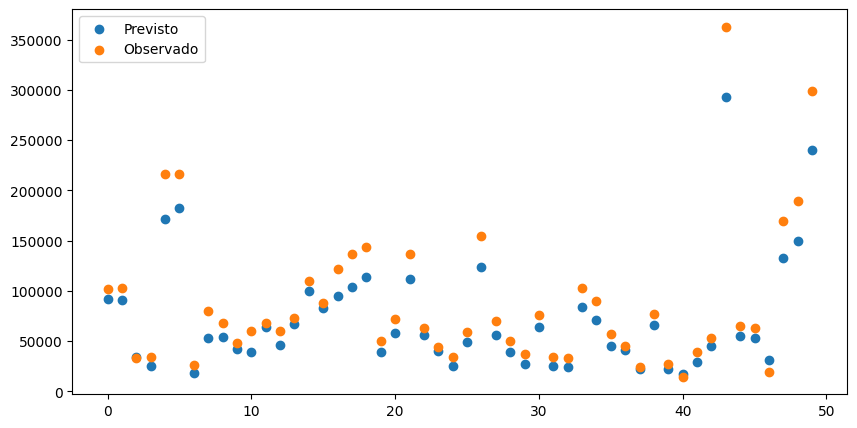

In [123]:
'''Pelo erro médio já podemos ter uma ideia que a previsão nos dados observados
terão uma queda de qualidade em relação aos dados do treino (coisa que não poderia
acontecer de forma tão brusca como ocorreu)'''
plt.figure(figsize=(10,5))
plt.scatter(range(50), prediction_test[:50], label='Previsto')
plt.scatter(range(50), y_test[:50], label='Observado')
plt.legend()

In [124]:
'''Podemos usar técnicas que buscam restringir o modelo tirar sua complexidade para que ele possa
generalizar melhor nos dados ainda não observados'''
mse_for = np.ones([len(train_data[0])-2, 1])

for i in range(1,len(train_data[0])-1):
    data_forward, _ = multi_dim.Forward_selection(i)
    test_forward = LR(data_forward, np_y)

    BB_forward = test_forward.least_square()
    hat_forward = test_forward.prediction(data_forward)
    mse_forward = test_forward.MSE(hat_forward, np_y)
    print(f"MSE test com {i} variáveis: {mse_forward}")

    # Para melhor interpretação podemos usar o erro médio
    erro_medio = np.mean(np_y - hat_forward) / np.mean(np_y)
    print(f"Erro médio com {i} variáveis: {erro_medio}\n")
    mse_for[i-1] =  mse_forward

MSE test com 1 variáveis: 61368615.93835387
Erro médio com 1 variáveis: 2.3932649364346808e-17

MSE test com 2 variáveis: 30205907.462179832
Erro médio com 2 variáveis: 2.456138845781694e-16

MSE test com 3 variáveis: 27751978.69557727
Erro médio com 3 variáveis: 4.666866626047628e-16

MSE test com 4 variáveis: 26781508.362067297
Erro médio com 4 variáveis: -2.07686719907552e-16



In [125]:
list(range(1, 4))

[1, 2, 3]

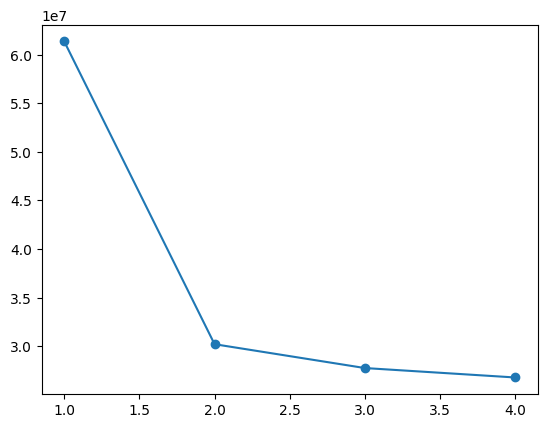

In [126]:
plt.plot(list(range(1, 5)), mse_for, linestyle='-', marker='o')

In [127]:
'''Iremos usar data set com 2 features (além do intercept), por conta de ter
reduzido bem o mse(aumentar para 3 features diminui pouco o erro)'''
# Selecionando os dados com os dois melhores features (segundo Forward_selection)
data_forward, pos = multi_dim.Forward_selection(2)

test_forward = LR(data_forward, np_y)
# Treinando com apenas os 2 features
BB_forward = test_forward.least_square()
# Selecionando os features nos dados não observados
forward_datatest = x_test[:,pos]
forward_datatest

array([[  1.        ,  13.53013974,  -1.01281771],
       [  1.        ,  17.00587403,  -1.90217555],
       [  1.        ,  51.76115223,  -2.00259832],
       ...,
       [  1.        , -10.60524316,  -4.63912982],
       [  1.        ,   4.85069973,   0.13468049],
       [  1.        ,  14.8021683 ,  -2.31619134]])

Podemos dizer que não houveram melhorias, o erro médio permaneceu
o mesmo, mas mesmo assim já é considerado melhor por conta de sua simplicidade,
(as chances de generalizar para novos dados é melhor,
mais fácil interpretação dos resultado obtidos)

In [128]:
predict_test = test_forward.prediction(forward_datatest)

mse_forward = test_forward.MSE(predict_test, y_test)
print("MSE: ",mse_forward)
# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(predict_test - y_test) / np.mean(y_test)
print("erro médio :", erro_medio) 

MSE:  478729616.9320649
erro médio : -0.17860109259329704


Backward selection trabalha na direção oposta. Deletando as variáveis que "menos ajudam" na qualidade do modelo

In [129]:
'''Podemos usar técnicas que buscam restringir o modelo tirar sua complexidade para que ele possa
generalizar melhor nos dados ainda não observados'''
mse_for = np.ones([len(train_data[0])-2, 1])

for i in range(1,len(train_data[0])-1):
    data_forward, _ = multi_dim.Backward_selection(i)
    test_forward = LR(data_forward, np_y)

    BB_forward = test_forward.least_square()
    hat_forward = test_forward.prediction(data_forward)
    mse_forward = test_forward.MSE(hat_forward, np_y)
    print(f"MSE test com {i} variáveis: {mse_forward}")

    # Para melhor interpretação podemos usar o erro médio
    erro_medio = np.mean(np_y - hat_forward) / np.mean(np_y)
    print(f"Erro médio com {i} variáveis: {erro_medio}\n")
    mse_for[i-1] =  mse_forward

MSE test com 1 variáveis: 2990762859.3052597
Erro médio com 1 variáveis: -1.10333569950887e-16

MSE test com 2 variáveis: 2990371934.196206
Erro médio com 2 variáveis: -1.36294409939331e-16

MSE test com 3 variáveis: 2989382759.414598
Erro médio com 3 variáveis: -3.8941259982666e-17

MSE test com 4 variáveis: 2976735432.253723
Erro médio com 4 variáveis: -4.5431469979776996e-17



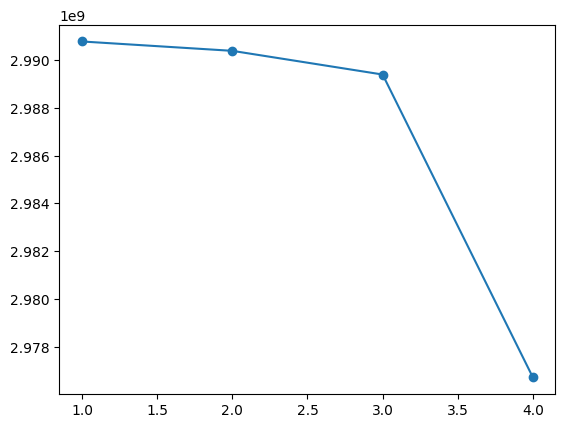

In [130]:
'''Faremos o teste com 1 variável, já que da 1 até a 3 houve pouca diferença. E com 4 variáveis já
que foi a mudança que mais trouce diferença no MSE'''
plt.plot(list(range(1,5)), mse_for, linestyle='-', marker='o')

In [131]:
'''Iremos usar data set com 1 features (além do intercept)'''
# Selecionando os dados com os dois melhores features (segundo Backward_selection)
data_backward, pos = multi_dim.Backward_selection(1)

test_backward = LR(data_backward, np_y)
# Treinando com apenas os 2 features
BB_backward= test_backward.least_square()
# Selecionando os features nos dados não observados
backward_datatest = np.delete(x_test, pos, axis=1)
backward_datatest[:10]

array([[ 1.        ,  0.06716162],
       [ 1.        ,  0.03498903],
       [ 1.        , -0.03557963],
       [ 1.        , -0.13108534],
       [ 1.        , -0.13281265],
       [ 1.        , -0.07086117],
       [ 1.        , -0.12808078],
       [ 1.        ,  0.14499935],
       [ 1.        , -0.1500814 ],
       [ 1.        , -0.06260832]])

In [132]:
predict_test = test_backward.prediction(backward_datatest)

mse_backward = test_backward.MSE(predict_test, y_test)
print("MSE: ",mse_backward)
# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(predict_test - y_test) / np.mean(y_test)
print("erro médio :", erro_medio) 

MSE:  4758116351.780055
erro médio : -0.20536412378428995


In [133]:
'''Iremos usar data set com 1 features (além do intercept)'''
# Selecionando os dados com os dois melhores features (segundo Backward_selection)
data_backward, pos = multi_dim.Backward_selection(4)

test_backward = LR(data_backward, np_y)
# Treinando com apenas os 2 features
BB_backward= test_backward.least_square()
# Selecionando os features nos dados não observados
backward_datatest = np.delete(x_test, pos, axis=1)
backward_datatest[:10]

array([[ 1.00000000e+00, -1.01281771e+00, -8.30647528e+02,
         1.08635864e+03,  6.71616207e-02],
       [ 1.00000000e+00, -1.90217555e+00, -8.79753763e+02,
         1.07505709e+03,  3.49890343e-02],
       [ 1.00000000e+00, -2.00259832e+00,  1.84720409e+02,
        -8.71514765e+00, -3.55796313e-02],
       [ 1.00000000e+00,  3.00826871e-01,  3.85868035e+01,
        -2.01503328e+01, -1.31085336e-01],
       [ 1.00000000e+00,  2.14756096e+00,  9.99620055e+02,
         2.10651149e+02, -1.32812654e-01],
       [ 1.00000000e+00,  1.47560964e-01,  6.93409323e+02,
         1.31435195e+02, -7.08611667e-02],
       [ 1.00000000e+00,  2.49455905e-01,  6.07230574e+01,
        -8.81549592e+00, -1.28080779e-01],
       [ 1.00000000e+00,  1.58457813e+00,  1.92713655e+02,
         2.19608356e+03,  1.44999354e-01],
       [ 1.00000000e+00,  3.82181865e-01, -6.95860615e+01,
        -7.31989591e+01, -1.50081403e-01],
       [ 1.00000000e+00,  2.48518110e+00,  1.05059066e+02,
        -1.83802271e+01

In [134]:
predict_test = test_backward.prediction(backward_datatest)

mse_backward = test_backward.MSE(predict_test, y_test)
print("MSE: ",mse_backward)
# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(predict_test - y_test) / np.mean(y_test)
print("erro médio :", erro_medio) 

MSE:  4738448478.301194
erro médio : -0.2054053217378781


In [135]:
coef_ridge = multi_dim.Ridge_Regression(2)

,price,spec_rating,display_size,resolution_width,resolution_height,warranty
0,49900,42.026128,-0.581678,-108.583224,-64.154312,-0.089732
1,39900,35.233317,2.294516,128.732709,28.460823,0.022862
2,26990,52.570327,-1.466991,113.034744,-58.454783,-0.012584
3,59729,28.925082,-0.558172,352.132971,92.852173,0.021250
4,69990,25.879415,-1.955616,612.913343,82.849719,0.013045
...,...,...,...,...,...,...
495,59900,32.142468,0.294784,-92.923241,-48.202254,-0.057162
496,55990,34.569479,-1.324436,-3.286348,-81.604057,-0.010939
497,19990,56.915359,0.098599,67.158648,-16.344064,-0.059426
498,47990,33.211701,0.059203,364.727842,202.802435,0.049160


In [196]:
# Alterando os coeficientes usando uma penalidade em seu tamanho
coef_ridge = multi_dim.Ridge_Regression(2)

# Organizando os dados do teste
dados_centralizados = x_test[:,1:] - np.mean(x_test, axis=0)[1:]
ridge_data = np.append(np.ones([x_test.shape[0], 1]), dados_centralizados, axis=1)
ridge_prediction = ridge_data.dot(coef_ridge)

mse_ridge = multi_dim.MSE(ridge_prediction, y_test)
print("MSE test: ", mse_ridge)

# Para melhor interpretação podemos usar o erro médio
erro_medio = np.mean(ridge_prediction - y_test) / np.mean(ridge_prediction)
print("erro médio :", erro_medio) 

MSE test:  112155290396688.53
erro médio : -0.2583998911229161
